## Training you own models for predictions

## Import library

In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

From previous one, your dataset folder should be like this.
```
.
└── Dataset/
    ├── Dog/
    │   ├── dogImg1.jpg
    │   ├── dogImg1.jpg
    │   └── ...
    ├── Cat/
    │   ├── catImg1.jpg
    │   ├── catImg1.jpg
    │   └── ...
    ├── Bird/
    │   ├── birdImg1.jpg
    │   ├── birdImg1.jpg
    │   └── ...
    ├── Hamster/
    │   ├── hamsterImg1.jpg
    │   ├── hamsterImg1.jpg
    │   └── ...
    └── ...\
```

## Demo dataset
Use your own dataset if you are training your models.  
Else just git clone this dataset for demo

In [14]:
!git clone https://github.com/reemo-dev/flowers10.git

fatal: destination path 'flowers10' already exists and is not an empty directory.


## Import dataset 
Input to tensorflow dataset format by image_dataset_from_directory

In [15]:
train_data_dir = "/content/flowers10/dataset"

# Higher = faster training but "slightly" lower accuracy
# more info https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network
batch_size = 256 

# model required size for images
imgSize = 224 

# 30%(0.3) for validation and 70%(0.7) for training
splitNum = 0.3 

# random seed for data shuffle
dataSeed = 1337 

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir, seed=dataSeed, validation_split=splitNum, subset="training",
  image_size=(imgSize, imgSize), color_mode='rgb'
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir, seed=dataSeed, validation_split=splitNum, subset="validation",
  image_size=(imgSize, imgSize), color_mode='rgb'
)

Found 1504 files belonging to 10 classes.
Using 1053 files for training.
Found 1504 files belonging to 10 classes.
Using 451 files for validation.


## Get dataset labels array and classes number 

In [16]:
classNum = len(train_ds.class_names)
classArr = train_ds.class_names
print(f"Total class number: {classNum}")
print(f"All label: {classArr}")

Total class number: 10
All label: ['Centaurea cyanus', 'Chrysanthemum segetum', 'Dipteracanthus repens', 'Echeveria glauca', 'Helianthus annuus', 'Melastoma malabathricum', 'Rhododendron moulmainense', 'Rosa laevigata', 'Solanum wrightii', 'Thunbergia erecta']


## Define data augmentation layer
See https://www.tensorflow.org/api_docs/python/tf/keras/layers for more layers setting

In [17]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
  ]
)

## Expending training data images number and apply data augmentation

In [18]:
# Expand your training dataset by expendRound numbers (Optional, set 0 for no additions)
expendRound = 1
temp_ds = train_ds
for i in range(expendRound):
    train_ds = train_ds.concatenate(temp_ds)

# Apply data_augmentation and resize_and_rescale for training set
train_ds = train_ds.map(lambda image,label:(data_augmentation(image),label))

## Define model from tensorflow pre-builded model
This time we use EfficientNetV2B0  
https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2/EfficientNetV2B0  

See https://www.tensorflow.org/api_docs/python/tf/keras/applications for more models

In [19]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    input_shape=(imgSize,imgSize,3),
    include_top=False,
    weights='imagenet'
)

# turn to true for better accuracy but longer training time
base_model.trainable = True 

# How many rounds to train
epochsRound = 3

# Learning rate 
base_learning_rate = 0.0001

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(0.2), # Set higher if over fitting
  tf.keras.layers.Dense(classNum, activation='softmax')
])

## Set model checkpoint for saving best round weights
##### (Optional setting)

In [20]:
# save model callback
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath=checkpoint_filepath,
  save_weights_only=True,
  monitor='val_accuracy',
  mode='max',
  save_best_only=True
)

## Set learnDecay for better late round accuracy
##### (Optional setting)

In [21]:
# set lr decay callback
def learnDecay(epoch, lr):
    if epoch < (epochsRound / 2):
        return lr
    else:
        return lr * tf.math.exp(-0.1)

learnDecayCallback = tf.keras.callbacks.LearningRateScheduler(learnDecay)

## Set model optimizer, loss

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
)

## Training and Callback the best round result for saving model

In [23]:
# Training
history = model.fit(
  train_ds, 
  epochs=epochsRound,
  validation_data=valid_ds, 
  callbacks=[model_checkpoint_callback, learnDecayCallback]
)

# Loading the best training round to fit into the models 
model.load_weights(checkpoint_filepath)
test_loss, test_acc = model.evaluate(valid_ds, verbose=2)
print(test_acc)

# Save your models
model.save("myTrainingModel.h5")

Epoch 1/3
66/66 [==============================] - 27s 242ms/step - loss: 1.4988 - accuracy: 0.6216 - val_loss: 0.7915 - val_accuracy: 0.9002 - lr: 1.0000e-04
Epoch 2/3
66/66 [==============================] - 14s 212ms/step - loss: 0.3534 - accuracy: 0.9653 - val_loss: 0.2816 - val_accuracy: 0.9512 - lr: 1.0000e-04
Epoch 3/3
66/66 [==============================] - 14s 214ms/step - loss: 0.0940 - accuracy: 0.9929 - val_loss: 0.1604 - val_accuracy: 0.9557 - lr: 9.0484e-05
15/15 - 1s - loss: 0.1604 - accuracy: 0.9557 - 1s/epoch - 82ms/step
0.9556540846824646


## Plot result

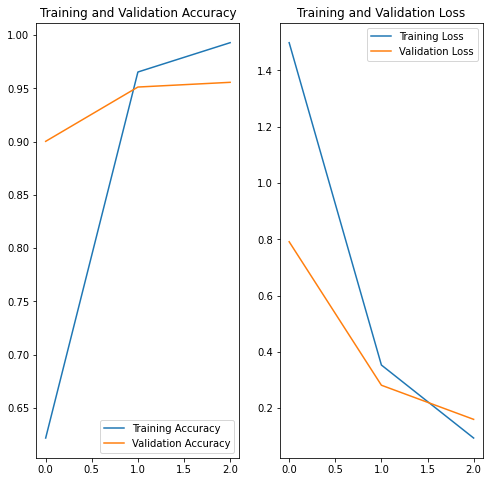

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochsRound)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Q&A

Q. My model validation accuracy is low, what should I do?  
A. Depends on the situations, several things that you may do to achieve higher accuracy.

First attempt:  
1. Adjust learning rate. 
2. Adjust Higher Droupout rate if over fitting occur.
3. Adjust your dataset (Remove bad images, unrelated data, add more data...).
4. Change the learnDecay method.  
5. Play more epochs.  

Late attempt: 
1. Try other data augmentation combinations.
2. Change other CNN model.
3. Adjust layer (add/remove) in tf.keras.Sequential.
5. Try another optimizer.
4. and more you can think of...  

Advance:
1. Apply stacking models (combinded model)
2. Try other better augmentations (CitMix / RandAug...)
3. Attempt attention models (https://github.com/leondgarse/keras_cv_attention_models).
4. See https://paperswithcode.com/sota/image-classification-on-imagenet for latest Image Classification technique.